## Adversarial Attacks on ImageNet Model

This notebook demonstrates several adversarial attacks (FGSM, PGD, CW, DeepFool) against a pre-trained ResNet50 model on a subset of ImageNet data.

## 1. Setup and imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.autograd.functional as F
import matplotlib.pyplot as plt
import numpy as np

## 2. Configuration

In [6]:
IMAGENET_VAL_DIR = './imagenet_val/'
LABEL_MAP_FILE = './imagenet_classes.txt'
BATCH_SIZE = 8     # How many images to process at once
NUM_IMAGES = 16    # Max number of images to test
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 806

# Set random seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if DEVICE == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

# Check device
print(f"Using device: {DEVICE}")

Using device: cuda


## 3. Load model and data

### 3.1 Load Pre-trained model (ResNet50)

In [7]:
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = model.to(DEVICE)
model.eval()

print("ResNet50 model loaded successfully.")

ResNet50 model loaded successfully.


### 3.2 Define image transformations

In [8]:
# Standard normalization for ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Inverse transform to display images later
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

inv_tensor_transform = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

### 3.3 Load ImageNet subset

In [9]:
# Create a dataset object
imagenet_data = datasets.ImageFolder(IMAGENET_VAL_DIR, preprocess)
print(f"Found {len(imagenet_data)} images in {IMAGENET_VAL_DIR}")
print(f"Class mapping (first 5): {list(imagenet_data.class_to_idx.items())[:5]}")

# Use a subset of the data
subset_indices = list(range(min(NUM_IMAGES, len(imagenet_data))))
imagenet_subset = data.Subset(imagenet_data, subset_indices)

# Create a DataLoader
test_loader = data.DataLoader(imagenet_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Created DataLoader with {len(imagenet_subset)} images.")

Found 50000 images in ./imagenet_val/
Class mapping (first 5): [('n01440764', 0), ('n01443537', 1), ('n01484850', 2), ('n01491361', 3), ('n01494475', 4)]
Created DataLoader with 16 images.


In [10]:
def get_class_name(class_idx):
    """Helper function to get class name from index using the loaded map."""
    # Ensure index is an integer, handle potential tensors/numpy ints
    if isinstance(class_idx, torch.Tensor):
        print("Class index is a tensor, converting to int.")
        class_idx = class_idx.item()
    class_idx = int(class_idx)

    return imagenet_classes.get(class_idx, f"Unknown Index {class_idx}")

### 3.4 Load class labels

In [11]:
# Load class labels 
with open(LABEL_MAP_FILE, "r") as f:
    lines = f.readlines()

temp_classes = {}
for line in lines:
    line = line.strip()
    parts = line.split(',', 1)
    idx = int(parts[0].strip())
    name = parts[1].strip().replace("'", "").replace('"', '')
    # Take only the main name if multiple are given (e.g., "great_white_shark, white_shark, ...")
    name = name.split(',')[0].strip()
    temp_classes[idx] = name

imagenet_classes = temp_classes
print(f"Loaded {len(imagenet_classes)} class names from index file.")
print("Sample class names:", list(imagenet_classes.items())[:5])

Loaded 1000 class names from index file.
Sample class names: [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


## 4. Implementation

Fast Gradient Sign Method (FGSM)

In [12]:
class FGSM:
    def __init__(self, model, eps):
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.eps = eps
        self.device = next(model.parameters()).device

    def __repr__(self):
        return f"FGSM Attack (eps={self.eps})"

    def __call__(self, images, labels):
        return self._fgsm_attack(images, labels)

    def _fgsm_attack(self, images, labels):
        # Keep a reference to the original images for clipping
        original_images = images.to(self.device).clone().detach()
        labels = labels.to(self.device)

        # Clone images to avoid modifying the original tensor and ensure requires_grad is set
        images_for_grad = original_images.clone().detach().requires_grad_(True)

        # Ensure model is in evaluation mode
        self.model.eval() # Correctly placed

        # Calculate loss
        outputs = self.model(images_for_grad)
        cost = self.loss_fn(outputs, labels)

        # Zero all existing gradients
        self.model.zero_grad()

        # Calculate gradients of loss w.r.t input images
        cost.backward()

        # Check if gradients were computed for the image
        if images_for_grad.grad is None:
             raise RuntimeError("Gradient for images is None. Ensure requires_grad=True is set on the input tensor.")

        # Collect the sign of the gradients
        sign_data_grad = images_for_grad.grad.sign()

        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = images_for_grad + self.eps * sign_data_grad

        # Clip the perturbed image to remain within the epsilon-ball of the original image.
        # This ensures the perturbation magnitude is bounded by epsilon in the L-infinity norm.
        # Since the input 'images' are already normalized, we clip relative to the normalized original image.
        min_val = original_images - self.eps
        max_val = original_images + self.eps
        perturbed_image = torch.clamp(perturbed_image, min=min_val, max=max_val)

        # Return the perturbed image, detached from the computation graph
        return perturbed_image.detach()

Projected Gradient Descent (PGD)

In [13]:
class PGD:
    def __init__(self, model, eps, alpha, steps):
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.device = next(model.parameters()).device

    def __repr__(self):
        return f"PGD(eps={self.eps}, alpha={self.alpha}, steps={self.steps})"

    def __call__(self, images, labels):
        return self._pgd_attack(images, labels)

    def _pgd_attack(self, images, labels):
        images = images.to(self.device).clone().detach()
        labels = labels.to(self.device)

        # Keep a reference to the original images for projection
        original_images = images.clone().detach()

        adv_images = images.clone().detach() # Start from original image

        self.model.eval() # Ensure model is in eval mode

        for _ in range(self.steps):
            adv_images.requires_grad_(True)

            # Calculate loss and gradients using self.model
            outputs = self.model(adv_images)
            cost = self.loss_fn(outputs, labels)

            # Zero gradients for self.model
            self.model.zero_grad()
            cost.backward()

            # Check if gradients were computed
            if adv_images.grad is None:
                # If no gradient, it might mean the loss didn't depend on the input
                # or the model part processing the input didn't run.
                # In this context, it likely means the image is already maximally wrong
                # or something unexpected happened. We can stop iterating for this image/batch.
                # print(f"Warning: Gradient for adv_images is None in PGD step. Stopping iteration.") # Optional warning
                break # Exit the loop for this batch

            # Collect the sign of the gradients
            sign_data_grad = adv_images.grad.sign()

            # Update adversarial images (gradient ascent step)
            # Detach adv_images before the update to prevent interference with gradient calculation in the next step
            adv_images = adv_images.detach() + self.alpha * sign_data_grad

            # Project back into the epsilon-ball around the original image
            # Calculate perturbation relative to original
            perturbation = adv_images - original_images

            # Clip perturbation to [-eps, eps] (L-infinity norm)
            perturbation = torch.clamp(perturbation, -self.eps, self.eps)

            # Apply clipped perturbation to original image to ensure it stays within the L-infinity ball
            adv_images = original_images + perturbation

            # Optional: Clip final image values to be valid (e.g., if inputs were [0,1] before normalization)
            # This depends on whether the original 'images' input to the function are expected
            # to be in a specific range (like [0,1]) or are already normalized.
            # Since the notebook uses normalized images, clipping based on normalized bounds might be needed
            # if the perturbation pushes values outside the valid normalized range.
            # However, the standard PGD often clips only the perturbation magnitude (as done above).
            # If clipping the final image is desired:
            mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
            min_val = (0 - mean) / std
            max_val = (1 - mean) / std
            adv_images = torch.clamp(adv_images, min=min_val, max=max_val)


        # Return the final perturbed image, detached from the computation graph
        return adv_images.detach()

Carlini & Wagner L2 (CW) attack

In [14]:
class CW:
    def __init__(self, model, c, kappa, steps, lr):
        self.model = model
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.device = next(model.parameters()).device

    def __repr__(self):
        return f"CW(c={self.c}, kappa={self.kappa}, steps={self.steps}, lr={self.lr})"

    def __call__(self, images, labels):
        return self._cw_l2_attack(images, labels)

    def _cw_l2_attack(self, images, labels):
        images = images.to(self.device).clone().detach()
        labels = labels.to(self.device)
        batch_size = images.shape[0]

        # We need the mean and std used in the original normalization
        mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
        images_orig_scale = images * std + mean

        # Clamp to ensure valid [0, 1] range after potential float inaccuracies
        images_orig_scale = torch.clamp(images_orig_scale, 0, 1)

        # Initialize perturbation variable 'w' in arctanh space
        # w = arctanh(2*x - 1)  => x = 0.5 * (tanh(w) + 1)
        # Add small epsilon to avoid infinity for 0 and 1
        w = torch.atanh(torch.clamp(images_orig_scale * 2 - 1, -1 + 1e-6, 1 - 1e-6)).detach().requires_grad_(True)

        optimizer = optim.AdamW([w], lr=self.lr)
        best_adv_images_norm_scale = images.clone().detach() # Store best normalized images
        best_l2 = torch.full((batch_size,), float('inf'), device=self.device)

        model.eval() # Ensure model is in eval mode

        for step in range(self.steps):
            optimizer.zero_grad()

            # Transform w back to image space [0, 1]
            adv_images_orig_scale = 0.5 * (torch.tanh(w) + 1)

            # Re-normalize for the model
            adv_images_norm_scale = (adv_images_orig_scale - mean) / std

            outputs = model(adv_images_norm_scale)
            one_hot_labels = torch.eye(outputs.shape[1], device=self.device)[labels]

            # Calculate CW loss components
            real = torch.sum(one_hot_labels * outputs, dim=1)
            # Max logit of non-target classes
            other = torch.max((1 - one_hot_labels) * outputs - one_hot_labels * 10000, dim=1)[0]

            # CW Loss f(x') = max(0, max_{i!=t}{Z(x')_i} - Z(x')_t + kappa)
            # We want to maximize 'other' and minimize 'real'
            f_loss = torch.clamp(other - real + self.kappa, min=0)

            # L2 distance loss (between original [0,1] and adversarial [0,1])
            l2_loss = torch.sum((adv_images_orig_scale - images_orig_scale).pow(2), dim=(1, 2, 3))

            # Total loss = c * f(x') + ||delta||_2^2
            # We minimize this total loss
            loss = self.c * f_loss + l2_loss

            # Sum losses over the batch for backward pass
            loss.sum().backward()
            optimizer.step()

            # Update best adversarial images found so far
            with torch.no_grad():
                # Check if the attack succeeded for each image in the batch
                pred_adv = torch.argmax(outputs, dim=1)
                attack_success = (pred_adv != labels)

                # Update images where the attack is successful *and* L2 is lower
                # Note: l2_loss is already squared L2 norm
                update_mask = (attack_success & (l2_loss < best_l2))
                if update_mask.any():
                    best_l2[update_mask] = l2_loss[update_mask]
                    best_adv_images_norm_scale[update_mask] = adv_images_norm_scale[update_mask].detach()

        # Return the best adversarial images found (in normalized scale)
        # If attack never succeeded for an image, it returns the original normalized image
        return best_adv_images_norm_scale.detach()

DeepFool (Simplified, Untargeted L2)

In [15]:
class DeepFool:
    def __init__(self, model, steps, overshoot, num_classes):
        self.model = model
        self.steps = steps
        self.overshoot = overshoot
        self.num_classes = num_classes
        self.device = next(model.parameters()).device

        # Calculate normalized bounds based on ImageNet normalization
        # These are the min/max values in the normalized space corresponding to [0, 1] pixel values
        mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
        self.min_val = (0 - mean) / std
        self.max_val = (1 - mean) / std


    def __repr__(self):
        return f"DeepFool(steps={self.steps}, overshoot={self.overshoot}, num_classes={self.num_classes})"

    def __call__(self, images, labels=None):
        # Note: labels are not used in untargeted DeepFool
        # but kept for consistency with the evaluation loop structure.
        return self._deepfool_attack(images)

    def _deepfool_attack(self, images):
        images = images.to(self.device).clone().detach()
        batch_size = images.shape[0]

        # Store original images
        original_images = images.clone().detach()
        # This will store the final adversarial images for the batch
        final_adv_images = images.clone().detach()

        model.eval()

        # Get initial predictions (needed to know when attack succeeds)
        with torch.no_grad():
            initial_outputs = model(images)
            initial_preds = torch.argmax(initial_outputs, dim=1)

        # Loop over images in the batch
        for idx in range(batch_size):
            # Process one image [1, C, H, W]
            # Start each image's attack from its original state
            img = original_images[idx:idx+1].clone().detach()
            img_initial_pred = initial_preds[idx].item()

            # Perturbation accumulated for *this* image across steps
            current_img_pert = torch.zeros_like(img, device=self.device)

            for step in range(self.steps):
                # Need gradients for the current perturbed image
                # Create a version of the image for this step's gradient calculation
                img_for_grad = img.clone().detach().requires_grad_(True)

                outputs = model(img_for_grad) # Shape [1, num_classes]
                current_pred = torch.argmax(outputs, dim=1).item()

                # If already misclassified relative to the original prediction, stop.
                if current_pred != img_initial_pred:
                    break

                # Optimized Gradient Calculation using Jacobian
                def model_logits(x):
                    return model(x)[0] # Output shape [num_classes]

                try:
                    grads_jacobian = F.jacobian(model_logits, img_for_grad, create_graph=False, strict=False)
                except Exception as e:
                    print(f"Jacobian calculation failed for image {idx} at step {step}: {e}")
                    break # Stop processing this image if Jacobian fails

                # Squeeze the batch dimension potentially added by jacobian: (num_classes, C, H, W)
                # Handle potential extra dimensions if jacobian behaves differently
                if grads_jacobian.dim() > 4: # e.g., (1, num_classes, C, H, W)
                    grads = grads_jacobian.squeeze(dim=0).squeeze(dim=1)
                elif grads_jacobian.dim() == 4: # (num_classes, C, H, W)
                     grads = grads_jacobian.squeeze(dim=1) # Should not happen with squeeze(0) above, but safer
                else:
                    print(f"Unexpected Jacobian shape: {grads_jacobian.shape} for image {idx} at step {step}")
                    break


                # Get logit and gradient for the current predicted class (still the initial pred at this stage)
                f_pred = outputs[0, current_pred].detach().item() # Logit of current (initial) prediction
                w_pred = grads[current_pred] # Gradient for current (initial) prediction

                min_pert_ratio = float('inf')
                closest_boundary_l = -1
                closest_w_diff = None # Initialize closest_w_diff

                # Find the closest class boundary (minimum perturbation ratio)
                for k in range(self.num_classes):
                    if k == current_pred: # Compare against the current prediction
                        continue

                    f_k = outputs[0, k].detach().item() # Logit of other class k
                    w_k = grads[k] # Gradient for other class k

                    # Difference in logits and gradients
                    f_diff = f_k - f_pred
                    w_diff = w_k - w_pred # shape [C, H, W]

                    # Use sum of squares for squared L2 norm
                    # Add small epsilon for numerical stability
                    w_diff_norm_sq = torch.sum(w_diff**2) + 1e-9

                    # Perturbation ratio: abs(f_diff) / ||w_diff||_2^2
                    pert_ratio_k = abs(f_diff) / w_diff_norm_sq

                    if pert_ratio_k < min_pert_ratio:
                        min_pert_ratio = pert_ratio_k
                        closest_boundary_l = k
                        closest_w_diff = w_diff # Store the w_diff for the closest boundary

                # If no boundary found (e.g., gradients were zero or identical)
                if closest_boundary_l == -1 or closest_w_diff is None:
                    print(f"Warning: DeepFool couldn't find a boundary for image {idx} at step {step}.")
                    break # Stop iterating steps for this image

                # Calculate the minimal perturbation vector for this step (L2)
                r_i = min_pert_ratio * closest_w_diff

                # Accumulate perturbation for this image
                current_img_pert += r_i

                # Update the image *for the next iteration* by applying the accumulated perturbation
                img = (original_images[idx:idx+1] + current_img_pert).detach()

                # Check if the classification has changed *after* this step's perturbation
                with torch.no_grad():
                    check_outputs = model(img)
                    check_pred = torch.argmax(check_outputs, dim=1).item()

                if check_pred != img_initial_pred:
                    break

            # After loop finishes (max steps reached or boundary crossed)
            # Apply overshoot to the total accumulated perturbation
            final_pert = (1 + self.overshoot) * current_img_pert
            # Calculate the final adversarial image
            adv_img = original_images[idx:idx+1] + final_pert

            # Clip the final adversarial image to the valid normalized range
            # This corresponds to clipping pixel values to [0, 1]
            final_adv_images[idx] = torch.clamp(adv_img, min=self.min_val, max=self.max_val).detach().squeeze(0)


        # Return the batch of final adversarial images
        return final_adv_images

## 5. Parameter impact analysis

In [16]:
def evaluate_attack(attack_instance, test_loader, model, device, num_images_to_process):
    """Evaluates a single attack instance on the test loader."""
    model.eval()
    attack_results = {'correct': 0, 'total': 0, 'images': [], 'preds': [], 'confidences': [], 'time': 0.0}
    clean_results = {'images': [], 'preds': [], 'labels': [], 'confidences': []}
    total_processed = 0

    for _, (images, labels) in enumerate(test_loader):
        if total_processed >= num_images_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        current_batch_size = images.shape[0]

        # Store clean info for comparison
        with torch.no_grad():
            outputs_clean = model(images)
            preds_clean = torch.argmax(outputs_clean, dim=1)
            softmax_clean = torch.softmax(outputs_clean, dim=1)
            confidences_clean = softmax_clean.gather(1, preds_clean.unsqueeze(1)).squeeze(1).cpu().tolist()
            if isinstance(confidences_clean, float): confidences_clean = [confidences_clean]

        clean_results['images'].extend(images.cpu())
        clean_results['preds'].extend(preds_clean.cpu().tolist())
        clean_results['labels'].extend(labels.cpu().tolist())
        clean_results['confidences'].extend(confidences_clean)

        # Generate and Evaluate Adversarial Images
        adv_images = attack_instance(images, labels)

        with torch.no_grad():
            outputs_adv = model(adv_images)
            preds_adv = torch.argmax(outputs_adv, dim=1)
            softmax_adv = torch.softmax(outputs_adv, dim=1)
            confidences_adv = softmax_adv.gather(1, preds_adv.unsqueeze(1)).squeeze(1).cpu().tolist()
            if isinstance(confidences_adv, float): confidences_adv = [confidences_adv]

        correct_adv = (preds_adv == labels).sum().item()
        attack_results['correct'] += correct_adv
        attack_results['total'] += current_batch_size
        attack_results['images'].extend(adv_images.cpu())
        attack_results['preds'].extend(preds_adv.cpu().tolist())
        attack_results['confidences'].extend(confidences_adv)

        total_processed += current_batch_size
        if total_processed >= num_images_to_process:
             print(f"  Processed {total_processed} images. Stopping.")
             break
        else:
             print(f"  Processed {total_processed}/{num_images_to_process} images...", end='\r')

    attack_results['accuracy'] = (attack_results['correct'] / attack_results['total']) * 100 if attack_results['total'] > 0 else 0
    print(f"Attack evaluation finished in {attack_results['time']:.2f} seconds. Accuracy: {attack_results['accuracy']:.2f}%")
    return attack_results, clean_results

In [17]:
subset_indices_param_test = list(range(min(NUM_IMAGES, len(imagenet_data))))
imagenet_subset_param_test = data.Subset(imagenet_data, subset_indices_param_test)
param_test_loader = data.DataLoader(imagenet_subset_param_test, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nParameter testing will use {NUM_IMAGES} images.")


Parameter testing will use 16 images.


### FGSM Parameter Impact (Epsilon)

We will vary the `epsilon` value for the FGSM attack and observe its effect on model accuracy and the generated images. Epsilon controls the magnitude of the perturbation.FGSM

In [18]:
# Controls the magnitude of the perturbation. Larger eps = stronger attack but more visible noise.
FGSM_EPSILONS = [0.001, 0.01, 0.07, 0.1, 0.3, 0.5]


--- Testing FGSM Epsilons ---

Testing FGSM with epsilon = 0.001


  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing FGSM with epsilon = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing FGSM with epsilon = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM with epsilon = 0.07
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM with epsilon = 0.07
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM with epsilon = 0.1
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM with epsilon = 0.1
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM with epsilon = 0.3
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 75.00%

Testing FGSM

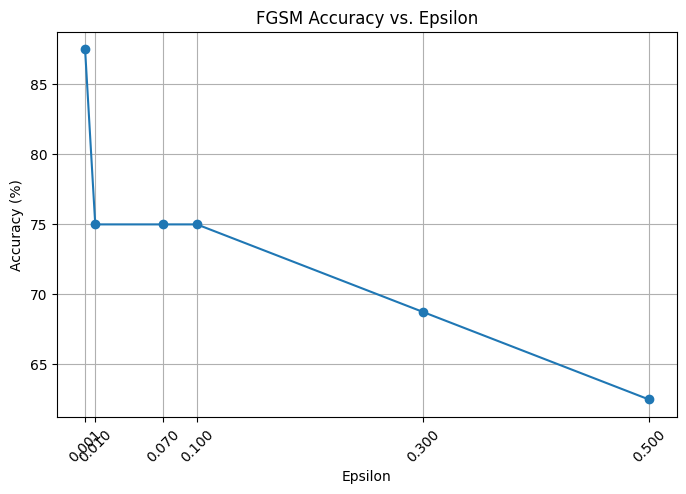

Best FGSM Epsilon found: 0.5 (Accuracy: 62.50%)


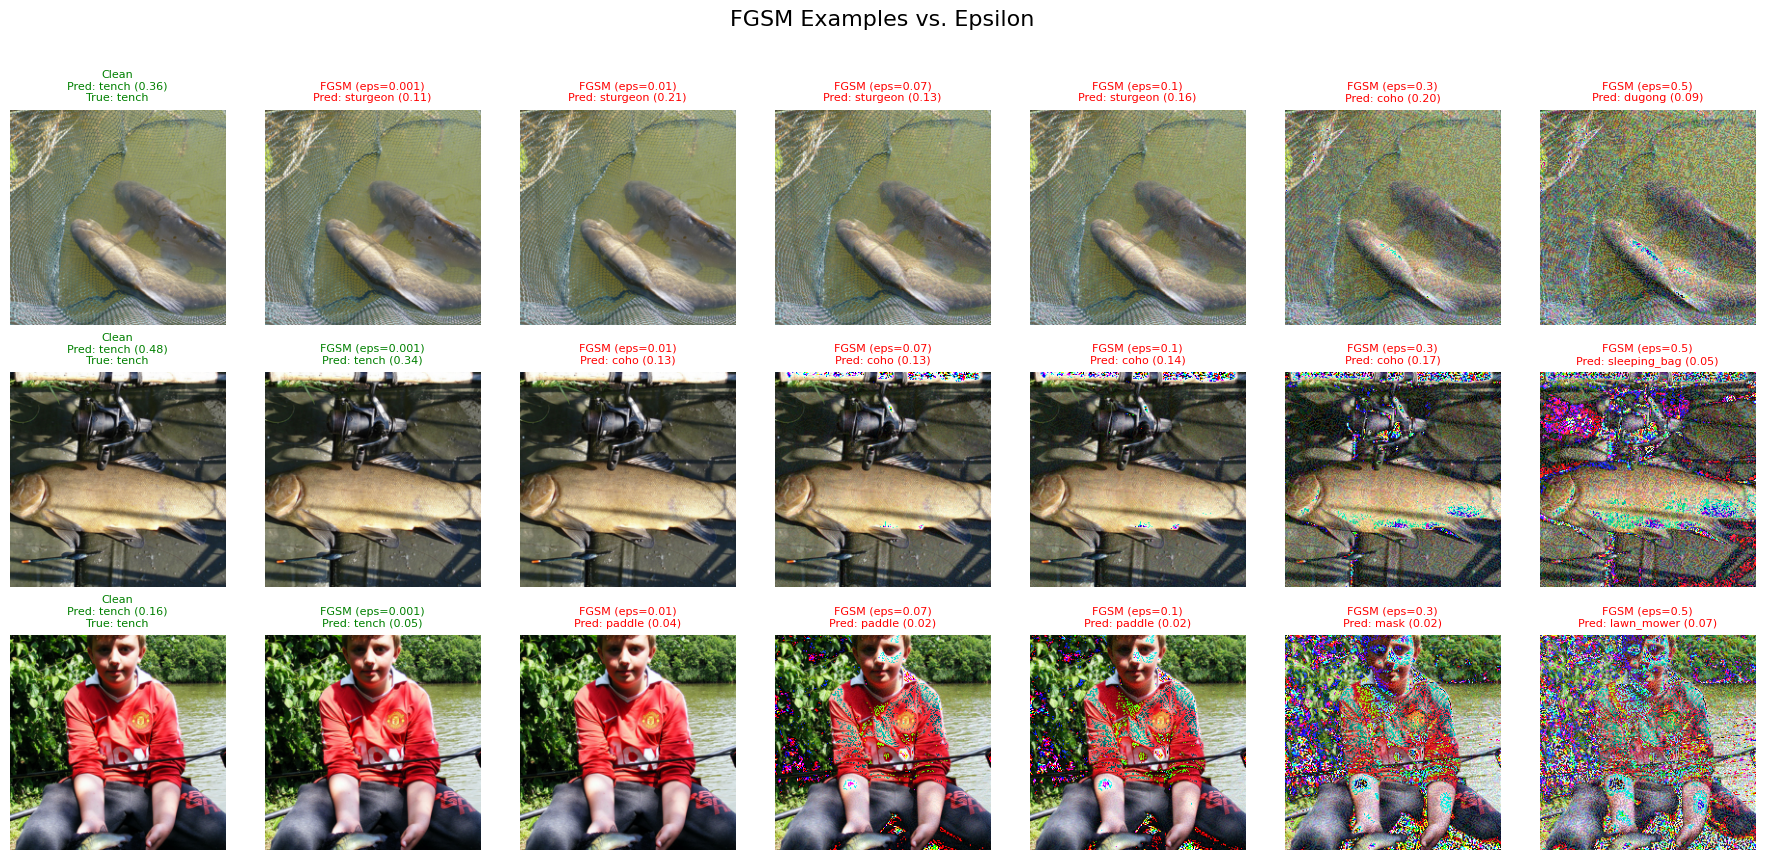

In [19]:
fgsm_results = {}
clean_data_for_fgsm = None

print("\n--- Testing FGSM Epsilons ---")
for eps in FGSM_EPSILONS:
    print(f"\nTesting FGSM with epsilon = {eps}")
    fgsm_attack = FGSM(model, eps=eps)
    results, clean_results = evaluate_attack(fgsm_attack, param_test_loader, model, DEVICE, NUM_IMAGES)
    fgsm_results[eps] = results
    if clean_data_for_fgsm is None:
        clean_data_for_fgsm = clean_results
print("----------------------------")

# Prepare data for plotting
fgsm_accuracies = [res['accuracy'] for res in fgsm_results.values()]

# Plot FGSM Accuracy vs Epsilon
plt.figure(figsize=(8, 5))
plt.plot(FGSM_EPSILONS, fgsm_accuracies, marker='o')
plt.title('FGSM Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xticks(FGSM_EPSILONS, rotation=45)
plt.grid(True)
plt.show()

# Find the best epsilon (lowest accuracy)
best_fgsm_epsilon_index = np.argmin(fgsm_accuracies)
best_fgsm_epsilon = FGSM_EPSILONS[best_fgsm_epsilon_index]
print(f"Best FGSM Epsilon found: {best_fgsm_epsilon} (Accuracy: {fgsm_accuracies[best_fgsm_epsilon_index]:.2f}%)")

# Visualize FGSM examples for different epsilons
num_samples_to_show = min(3, NUM_IMAGES)
fig, axs = plt.subplots(num_samples_to_show, len(FGSM_EPSILONS) + 1, figsize=(18, 3 * num_samples_to_show))
fig.suptitle("FGSM Examples vs. Epsilon", fontsize=16)

for i in range(num_samples_to_show):
    # Display clean image
    clean_img_tensor = clean_data_for_fgsm['images'][i]
    clean_pred_idx = clean_data_for_fgsm['preds'][i]
    true_label_idx = clean_data_for_fgsm['labels'][i]
    clean_conf = clean_data_for_fgsm['confidences'][i]
    clean_img_pil = inv_tensor_transform(clean_img_tensor)

    ax = axs[i, 0]
    ax.imshow(clean_img_pil)
    title_clean = f"Clean\nPred: {get_class_name(clean_pred_idx)} ({clean_conf:.2f})\nTrue: {get_class_name(true_label_idx)}"
    ax.set_title(title_clean, color=("green" if clean_pred_idx == true_label_idx else "red"), fontsize=8)
    ax.axis('off')

    # Display adversarial images for each epsilon
    for j, eps in enumerate(FGSM_EPSILONS):
        adv_img_tensor = fgsm_results[eps]['images'][i]
        adv_pred_idx = fgsm_results[eps]['preds'][i]
        adv_conf = fgsm_results[eps]['confidences'][i]
        adv_img_pil = inv_tensor_transform(adv_img_tensor)

        ax = axs[i, j + 1]
        ax.imshow(adv_img_pil)
        title_adv = f"FGSM (eps={eps})\nPred: {get_class_name(adv_pred_idx)} ({adv_conf:.2f})"
        ax.set_title(title_adv, color=("green" if adv_pred_idx == true_label_idx else "red"), fontsize=8)
        ax.axis('off')

plt.tight_layout(h_pad=3, rect=[0, 0.03, 1, 0.95])
plt.show()

### PGD Parameter Impact (Epsilon, Alpha, Steps)

Now, let's vary `epsilon`, `alpha`, and `steps` for the PGD attack to find the combination that results in the lowest model accuracy (most effective attack).
- `epsilon`: Maximum allowed perturbation size (L-infinity norm).
- `alpha`: Step size for each iteration.
- `steps`: Number of iterations.

In [20]:
# Maximum perturbation allowed. Larger eps = stronger attack but more visible noise.
PGD_EPSILONS = [0.001, 0.01, 0.07, 0.1, 0.3, 0.5]
# Step size for each iteration. Smaller alpha = more iterations needed to reach eps.
PGD_ALPHAS = [0.001, 0.01, 0.1]
# Number of iterations. More steps = potentially stronger attack but slower.
PGD_STEPS = [10, 20, 50]

In [21]:
pgd_results = {}
clean_data_for_pgd = None
min_pgd_accuracy = float('inf')
best_pgd_params = None

print("\n--- Testing PGD Parameter Combinations ---")
for eps in PGD_EPSILONS:
    for alpha in PGD_ALPHAS:
        for steps in PGD_STEPS:
            params = (eps, alpha, steps)
            print(f"\nTesting PGD with epsilon = {eps}, alpha = {alpha}, steps = {steps}")
            pgd_attack = PGD(model, eps=eps, alpha=alpha, steps=steps)
            results, clean_results = evaluate_attack(pgd_attack, param_test_loader, model, DEVICE, NUM_IMAGES)
            pgd_results[params] = results
            if clean_data_for_pgd is None:
                clean_data_for_pgd = clean_results

            # Track the best parameters (lowest accuracy)
            if results['accuracy'] < min_pgd_accuracy:
                min_pgd_accuracy = results['accuracy']
                best_pgd_params = params

print("-----------------------------------------")

# Find the best combination (lowest accuracy)
if best_pgd_params:
    best_pgd_epsilon, best_pgd_alpha, best_pgd_steps = best_pgd_params
    print(f"Best PGD Combination found: Epsilon={best_pgd_epsilon}, Alpha={best_pgd_alpha}, Steps={best_pgd_steps} (Accuracy: {min_pgd_accuracy:.2f}%)")
else:
    print("Could not determine best PGD parameters.")
    # Assign default values if no results were found (should not happen in normal execution)
    best_pgd_epsilon = PGD_EPSILONS[0]
    best_pgd_alpha = PGD_ALPHAS[0]
    best_pgd_steps = PGD_STEPS[0]

# Note: The previous plotting and visualization code assumed only epsilon varied.
# It has been removed as it's not directly applicable to multi-parameter testing.
# You could add new plots here to visualize the multi-dimensional results if needed,
# e.g., heatmaps or separate plots for slices of the parameter space.

# Example: Print all results
print("\n--- All PGD Results ---")
for params, result in pgd_results.items():
    eps, alpha, steps = params
    print(f"Eps={eps}, Alpha={alpha}, Steps={steps}: Accuracy={result['accuracy']:.2f}% ({result['correct']}/{result['total']})")
print("-----------------------")


--- Testing PGD Parameter Combinations ---

Testing PGD with epsilon = 0.001, alpha = 0.001, steps = 10
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon = 0.001, alpha = 0.001, steps = 20
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon = 0.001, alpha = 0.001, steps = 20
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon = 0.001, alpha = 0.001, steps = 50
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon = 0.001, alpha = 0.001, steps = 50
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon = 0.001, alpha = 0.01, steps = 10
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 87.50%

Testing PGD with epsilon =

### PGD Results Heatmap Visualization

The following heatmaps show the model accuracy for different combinations of PGD parameters. Each heatmap corresponds to a fixed number of `steps`. Lower accuracy (darker colors) indicates a more effective attack configuration.

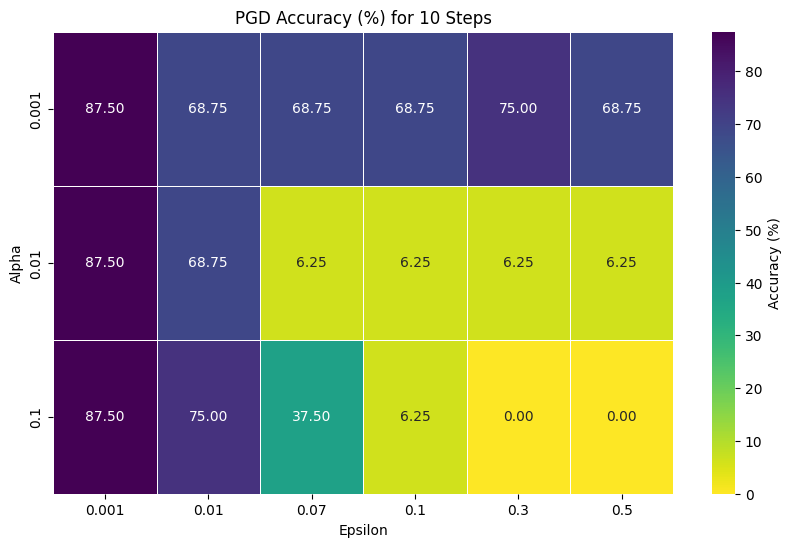

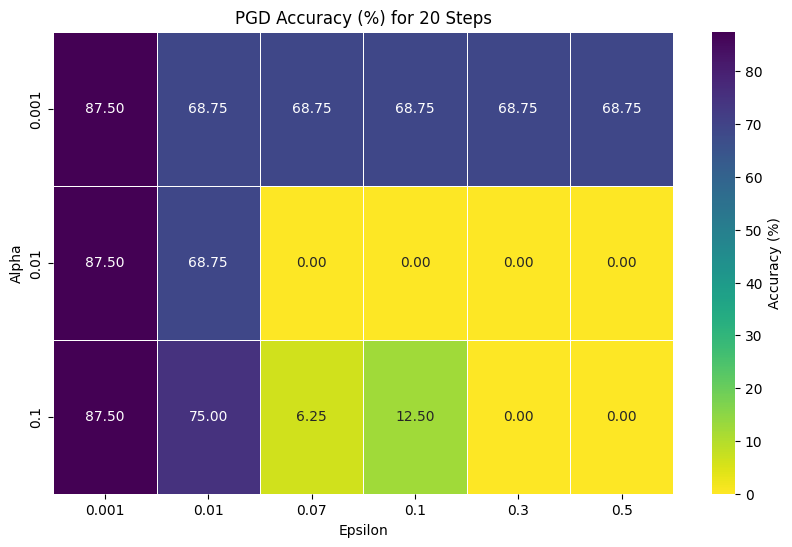

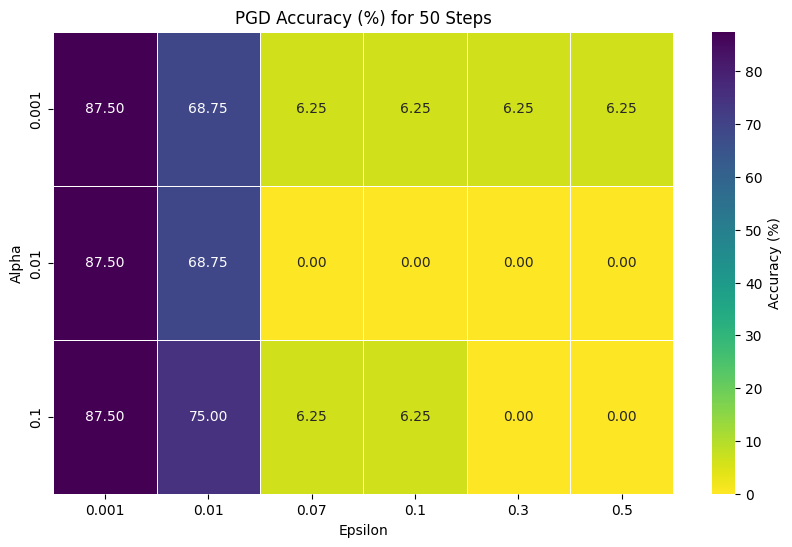

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create heatmaps for each number of steps
for steps_val in PGD_STEPS:
    # Prepare data for the heatmap for the current steps_val
    heatmap_data = pd.DataFrame(index=PGD_ALPHAS, columns=PGD_EPSILONS)
    for params, result in pgd_results.items():
        eps, alpha, steps = params
        if steps == steps_val:
            # Use .loc for potentially non-sequential index/columns
            heatmap_data.loc[alpha, eps] = result['accuracy']

    # Convert data to numeric, coercing errors (e.g., if a combination was missed)
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis_r", 
                linewidths=.5, cbar_kws={'label': 'Accuracy (%)'})
    plt.title(f'PGD Accuracy (%) for {steps_val} Steps')
    plt.xlabel('Epsilon')
    plt.ylabel('Alpha')
    plt.show()

### CW Parameter Impact (C)

For the Carlini & Wagner (CW) L2 attack, we'll vary the constant `c`. This parameter controls the trade-off between minimizing the perturbation (L2 norm) and ensuring misclassification. Higher `c` values prioritize misclassification more strongly, potentially leading to lower accuracy but possibly larger perturbations. We keep `kappa`, `steps`, and `lr` constant.

*Note: CW attack is computationally intensive, especially with higher steps. The parameter testing might take a while.*

In [23]:
# CW:
# Controls the trade-off between perturbation magnitude and classification confidence. Higher c = stronger attack.
CW_CS = [100, 1000, 10000]
# Number of optimization steps.
CW_STEPS = 100
# Learning rate for the optimizer.
CW_LR = 0.01
# Confidence parameter. Increase to make misclassification more confident. 0 means just misclassification.
CW_KAPPA = 0


--- Testing CW C Values ---
(Using reduced steps=100 for faster testing)
Testing CW with c = 100, kappa = 0, steps = 100, lr = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
Testing CW with c = 1000, kappa = 0, steps = 100, lr = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
Testing CW with c = 1000, kappa = 0, steps = 100, lr = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
Testing CW with c = 10000, kappa = 0, steps = 100, lr = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
Testing CW with c = 10000, kappa = 0, steps = 100, lr = 0.01
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
-------------------------
  Processed 16 images. Stopping.
Attack evaluation finished in 0.00 seconds. Accuracy: 93.75%
-------------------------


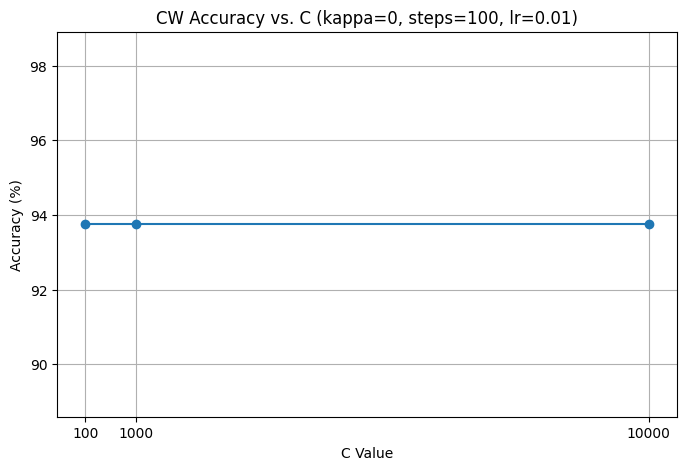

Best CW C value found: 100 (Accuracy: 93.75%)


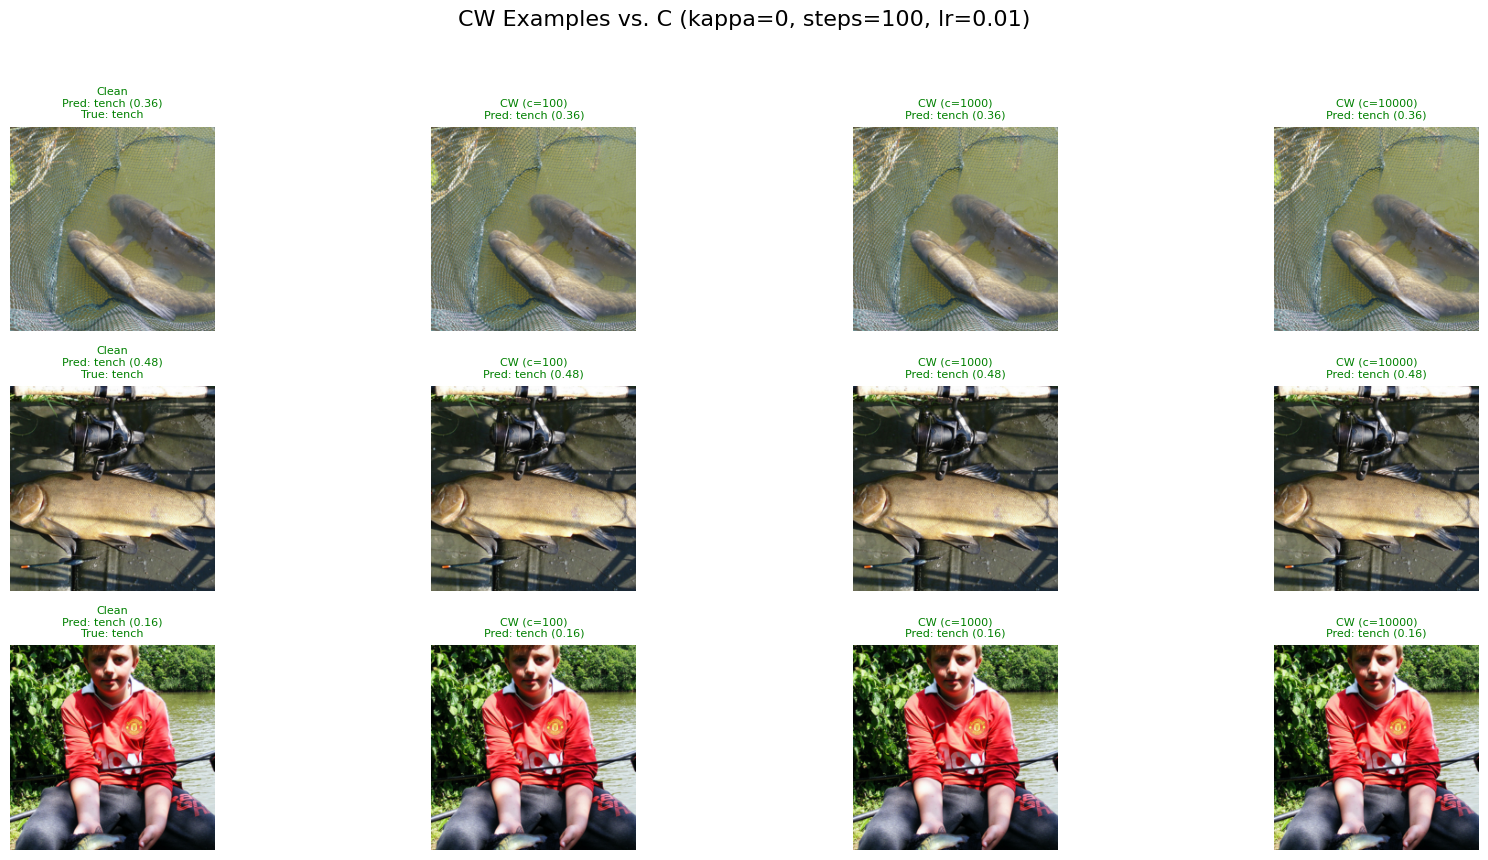

In [24]:
cw_results = {}
clean_data_for_cw = None # To store clean data just once

print("\n--- Testing CW C Values ---")
print(f"(Using reduced steps={CW_STEPS} for faster testing)")
for c_val in CW_CS:
    print(f"Testing CW with c = {c_val}, kappa = {CW_KAPPA}, steps = {CW_STEPS}, lr = {CW_LR}")
    cw_attack = CW(model, c=c_val, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR)
    results, clean_results = evaluate_attack(cw_attack, param_test_loader, model, DEVICE, NUM_IMAGES)
    cw_results[c_val] = results
    if clean_data_for_cw is None:
        clean_data_for_cw = clean_results
print("-------------------------")

# Prepare data for plotting
cw_accuracies = [res['accuracy'] for res in cw_results.values()]

# Plot CW Accuracy vs C
plt.figure(figsize=(8, 5))
plt.plot(CW_CS, cw_accuracies, marker='o')
plt.title(f'CW Accuracy vs. C (kappa={CW_KAPPA}, steps={CW_STEPS}, lr={CW_LR})')
plt.xlabel('C Value')
plt.ylabel('Accuracy (%)')
plt.xticks(CW_CS)
plt.grid(True)
plt.show()

# Find the best C value (lowest accuracy)
best_cw_c_index = np.argmin(cw_accuracies)
best_cw_c = CW_CS[best_cw_c_index]
print(f"Best CW C value found: {best_cw_c} (Accuracy: {cw_accuracies[best_cw_c_index]:.2f}%)")


# Visualize CW examples for different C values
num_samples_to_show = min(3, NUM_IMAGES)
fig, axs = plt.subplots(num_samples_to_show, len(CW_CS) + 1, figsize=(18, 3 * num_samples_to_show))
fig.suptitle(f"CW Examples vs. C (kappa={CW_KAPPA}, steps={CW_STEPS}, lr={CW_LR})", fontsize=16)

for i in range(num_samples_to_show):
    # Display clean image
    clean_img_tensor = clean_data_for_cw['images'][i]
    clean_pred_idx = clean_data_for_cw['preds'][i]
    true_label_idx = clean_data_for_cw['labels'][i]
    clean_conf = clean_data_for_cw['confidences'][i]
    clean_img_pil = inv_tensor_transform(clean_img_tensor)

    ax = axs[i, 0]
    ax.imshow(clean_img_pil)
    title_clean = f"Clean\nPred: {get_class_name(clean_pred_idx)} ({clean_conf:.2f})\nTrue: {get_class_name(true_label_idx)}"
    ax.set_title(title_clean, color=("green" if clean_pred_idx == true_label_idx else "red"), fontsize=8)
    ax.axis('off')

    # Display adversarial images for each C value
    for j, c_val in enumerate(CW_CS):
        # Check if results exist for this c_val (attack might fail)
        if c_val in cw_results and i < len(cw_results[c_val]['images']):
             adv_img_tensor = cw_results[c_val]['images'][i]
             adv_pred_idx = cw_results[c_val]['preds'][i]
             adv_conf = cw_results[c_val]['confidences'][i]
             adv_img_pil = inv_tensor_transform(adv_img_tensor)

             ax = axs[i, j + 1]
             ax.imshow(adv_img_pil)
             title_adv = f"CW (c={c_val})\nPred: {get_class_name(adv_pred_idx)} ({adv_conf:.2f})"
             ax.set_title(title_adv, color=("green" if adv_pred_idx == true_label_idx else "red"), fontsize=8)
             ax.axis('off')
        else:
             # Handle cases where attack might have failed or skipped for a specific image/param
             ax = axs[i, j + 1]
             ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
             ax.set_title(f"CW (c={c_val})\nPred: N/A", fontsize=8)
             ax.axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### DeepFool

In [25]:
# DeepFool:
# Maximum number of iterations to find the boundary. Beware: increasing will make process painfully slow.
DF_STEPS = 10
# Factor to push the image slightly over the boundary.
DF_OVERSHOOT = 0.02
# Model specific; ResNet50 is trained on ImageNet with 1000 classes.
NUM_CLASSES = 1000

In [26]:
# TODO: Implement DeepFool attack

## 6. Comparison using best found parameters

In [27]:
# Initialize attacks dictionary
attacks = {}

# Add attacks using the best parameters found
attacks['FGSM'] = FGSM(model, best_fgsm_epsilon)
# Use the best combination found from the parameter sweep
attacks['PGD'] = PGD(model, best_pgd_epsilon, best_pgd_alpha, best_pgd_steps)
attacks['CW'] = CW(model, best_cw_c, CW_KAPPA, CW_STEPS, CW_LR)

# Note: Uncomment to use DeepFool attack, but beware of the performance hit
#attacks['DeepFool'] = DeepFool(model, DF_STEPS, DF_OVERSHOOT, NUM_CLASSES)

print("Initialized Attacks:")
for name, attack in attacks.items():
    print(f"- {name}: {attack}")

Initialized Attacks:
- FGSM: FGSM Attack (eps=0.5)
- PGD: PGD(eps=0.07, alpha=0.01, steps=20)
- CW: CW(c=100, kappa=0, steps=100, lr=0.01)


### Run Attacks and Evaluate

In [28]:
results = {'clean': {'correct': 0, 'total': 0, 'images': [], 'preds': [], 'labels': [], 'confidences': []}}
for attack_name in attacks.keys():
    results[attack_name] = {'correct': 0, 'total': 0, 'images': [], 'preds': [], 'confidences': []}

print("\nStarting evaluation...")
total_processed = 0

for i, (images, labels) in enumerate(test_loader):
    # Stop if we reach the target number of images
    if total_processed >= NUM_IMAGES:
        break
    
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    current_batch_size = images.shape[0]

    # Evaluate on Clean Images
    with torch.no_grad():
        outputs_clean = model(images)
        preds_clean = torch.argmax(outputs_clean, dim=1)

        # Confidence calculation
        softmax_clean = torch.softmax(outputs_clean, dim=1)
        # Gather the confidence for the predicted class
        confidences_clean_tensor = softmax_clean.gather(1, preds_clean.unsqueeze(1)).squeeze(1)
        confidences_clean_list = confidences_clean_tensor.cpu().tolist()

        # Handle batch size 1 case where tolist() might return a float
        if isinstance(confidences_clean_list, float):
            confidences_clean_list = [confidences_clean_list]

    correct_clean = (preds_clean == labels).sum().item()
    results['clean']['correct'] += correct_clean
    results['clean']['total'] += current_batch_size
    results['clean']['images'].extend(images.cpu())
    results['clean']['preds'].extend(preds_clean.cpu().tolist())
    results['clean']['labels'].extend(labels.cpu().tolist())
    results['clean']['confidences'].extend(confidences_clean_list)

    print(f"  Batch {i+1}/{len(test_loader)}: Processing {current_batch_size} images...")

    # Generate and Evaluate Adversarial Images
    for attack_name, attack in attacks.items():
        adv_images = attack(images, labels)

        # Evaluate on adversarial images
        with torch.no_grad():
            outputs_adv = model(adv_images)
            preds_adv = torch.argmax(outputs_adv, dim=1)
            # Confidence calculation
            softmax_adv = torch.softmax(outputs_adv, dim=1)
            confidences_adv_tensor = softmax_adv.gather(1, preds_adv.unsqueeze(1)).squeeze(1)
            confidences_adv_list = confidences_adv_tensor.cpu().tolist()
            # Handle batch size 1 case
            if isinstance(confidences_adv_list, float):
                confidences_adv_list = [confidences_adv_list]

        correct_adv = (preds_adv == labels).sum().item()
        results[attack_name]['correct'] += correct_adv
        results[attack_name]['total'] += current_batch_size
        results[attack_name]['images'].extend(adv_images.cpu())
        results[attack_name]['preds'].extend(preds_adv.cpu().tolist())
        results[attack_name]['confidences'].extend(confidences_adv_list)

        print(f"    {attack_name} finished. Accuracy: {correct_adv}/{current_batch_size}")

    total_processed += current_batch_size
    if total_processed >= NUM_IMAGES:
        print(f"\nReached target number of images ({NUM_IMAGES}). Stopping.")
        break

print("\nEvaluation finished.")


Starting evaluation...
  Batch 1/2: Processing 8 images...
    FGSM finished. Accuracy: 4/8
    FGSM finished. Accuracy: 4/8
    PGD finished. Accuracy: 0/8
    PGD finished. Accuracy: 0/8
    CW finished. Accuracy: 8/8
  Batch 2/2: Processing 8 images...
    CW finished. Accuracy: 8/8
  Batch 2/2: Processing 8 images...
    FGSM finished. Accuracy: 6/8
    FGSM finished. Accuracy: 6/8
    PGD finished. Accuracy: 0/8
    PGD finished. Accuracy: 0/8
    CW finished. Accuracy: 7/8

Reached target number of images (16). Stopping.

Evaluation finished.
    CW finished. Accuracy: 7/8

Reached target number of images (16). Stopping.

Evaluation finished.


### Analyze Results

In [29]:
# Calculate and print accuracy and confidence
print("-" * 30)
print("Accuracy and Average Confidence Results:")
print("-" * 30)

acc_clean = (results['clean']['correct'] / results['clean']['total']) * 100 if results['clean']['total'] > 0 else 0
avg_conf_clean = np.mean(results['clean']['confidences']) if results['clean']['confidences'] else 0

print(f"Clean Accuracy: {results['clean']['correct']}/{results['clean']['total']} ({acc_clean:.2f}%)")
print(f"Clean Avg Confidence: {avg_conf_clean:.4f}")
print("-" * 30)

for attack_name in attacks.keys():
    total_adv = results[attack_name]['total']
    correct_adv = results[attack_name]['correct']
    confidences_adv = results[attack_name]['confidences']

    acc_adv = (correct_adv / total_adv) * 100 if total_adv > 0 else 0
    avg_conf_adv = np.mean(confidences_adv) if confidences_adv else 0

    print(f"{attack_name} Accuracy: {correct_adv}/{total_adv} ({acc_adv:.2f}%)")
    print(f"{attack_name} Avg Confidence: {avg_conf_adv:.4f}")
    print("-" * 30)

------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 15/16 (93.75%)
Clean Avg Confidence: 0.4465
------------------------------
FGSM Accuracy: 10/16 (62.50%)
FGSM Avg Confidence: 0.1858
------------------------------
PGD Accuracy: 0/16 (0.00%)
PGD Avg Confidence: 0.4857
------------------------------
CW Accuracy: 15/16 (93.75%)
CW Avg Confidence: 0.4465
------------------------------


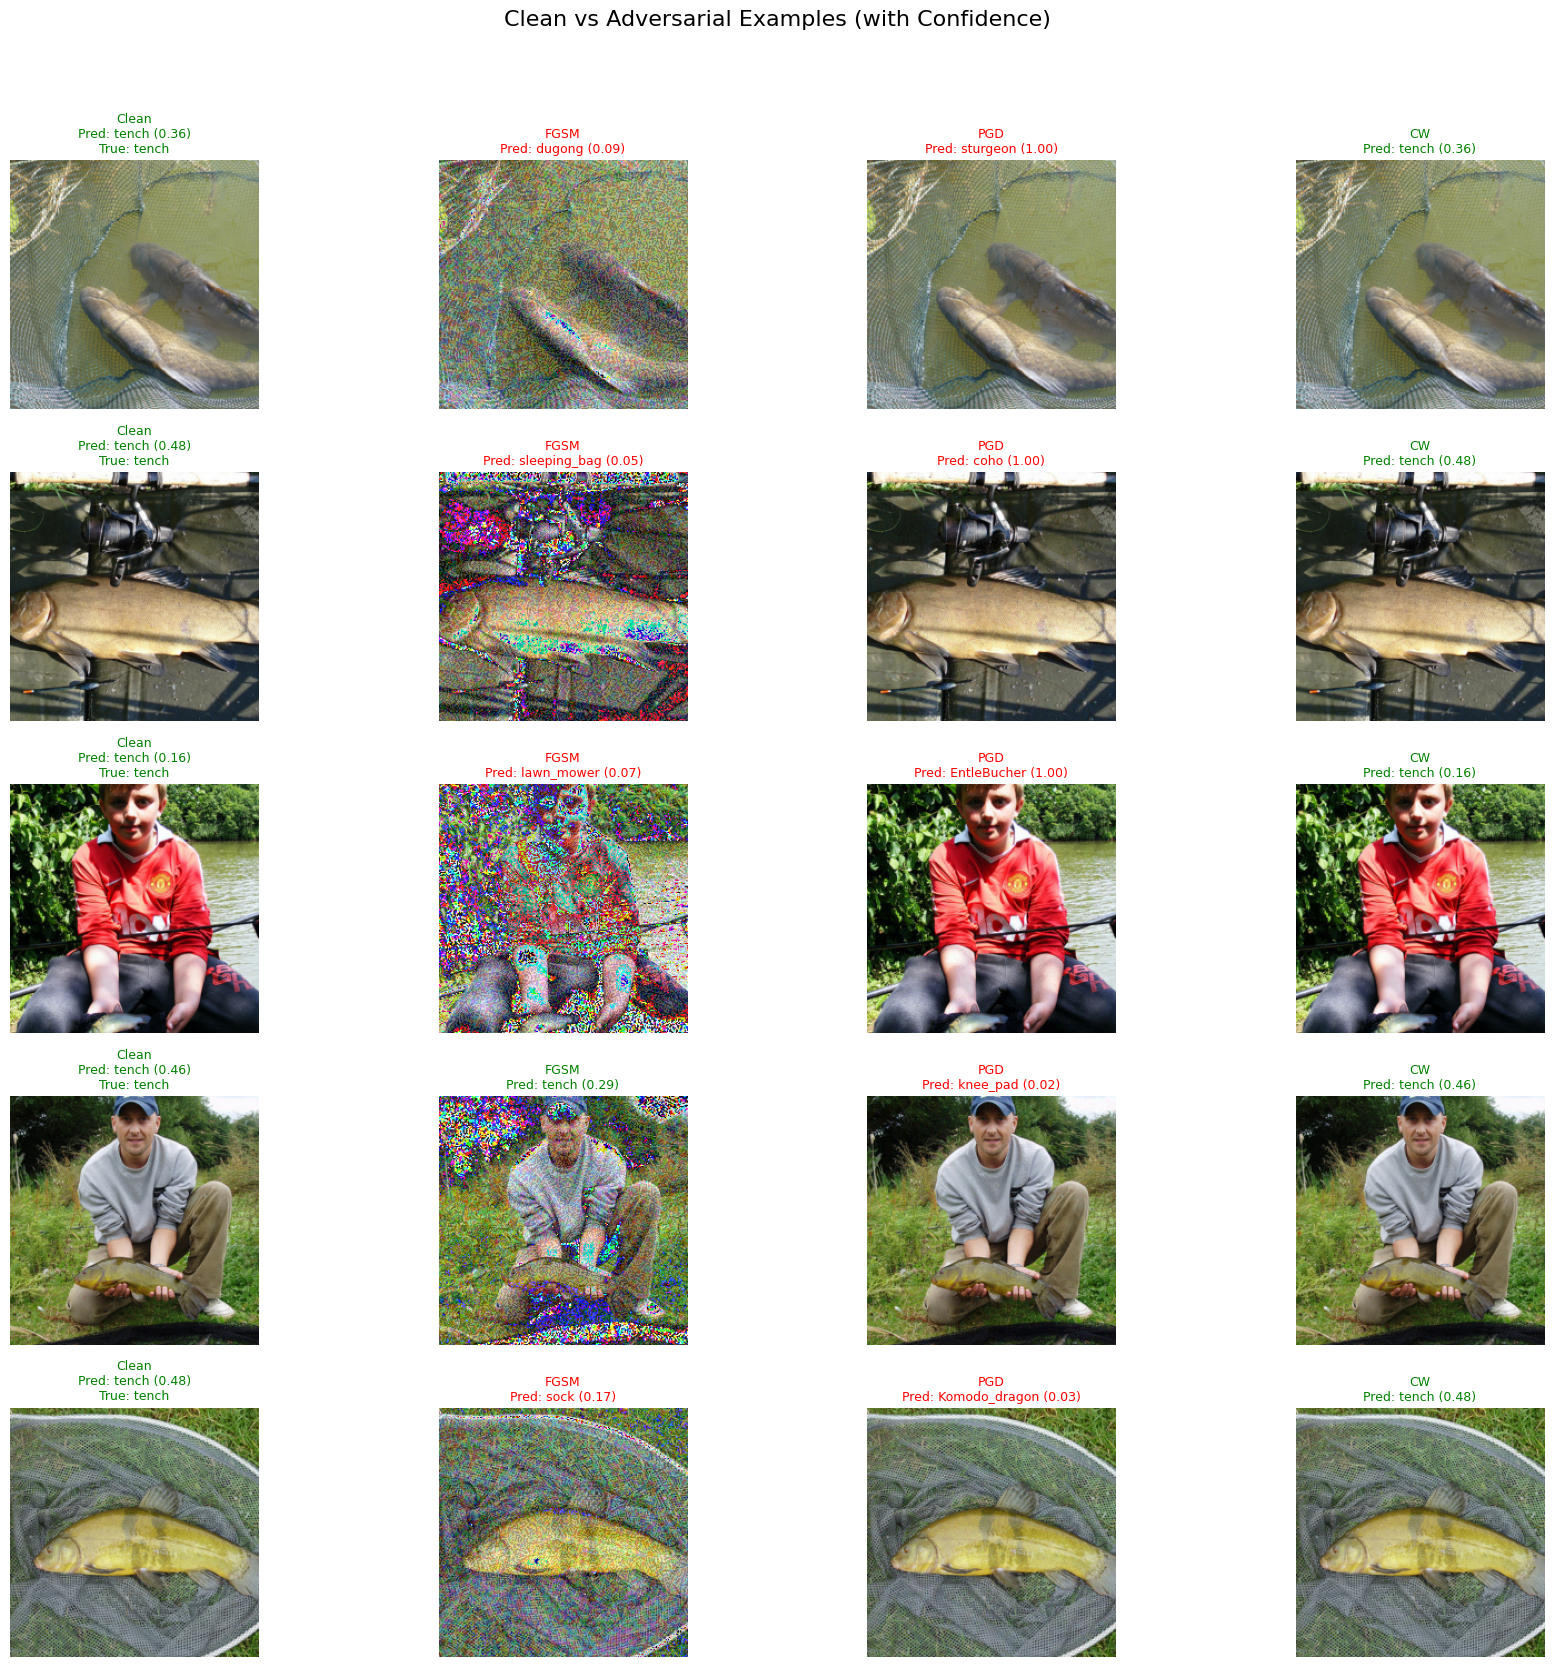

In [30]:
# Visualize sample results
num_samples_to_show = min(5, results['clean']['total'])

# Adjust figsize if titles become too long
fig, axs = plt.subplots(num_samples_to_show, len(attacks) + 1, figsize=(18, 3.5 * num_samples_to_show))
fig.suptitle("Clean vs Adversarial Examples (with Confidence)", fontsize=16)

for i in range(num_samples_to_show):
    # Get clean image and info
    clean_img_tensor = results['clean']['images'][i]
    clean_pred_idx = results['clean']['preds'][i]
    true_label_idx = results['clean']['labels'][i]
    clean_conf = results['clean']['confidences'][i]

    # Denormalize for display
    clean_img_pil = inv_tensor_transform(clean_img_tensor)

    # Display clean image
    ax = axs[i, 0]
    ax.imshow(clean_img_pil)
    # Add confidence to title
    title_clean = f"Clean\nPred: {get_class_name(clean_pred_idx)} ({clean_conf:.2f})\nTrue: {get_class_name(true_label_idx)}"
    ax.set_title(title_clean,
                    color=("green" if clean_pred_idx == true_label_idx else "red"),
                    fontsize=9)
    ax.axis('off')

    # Display adversarial images
    col_idx = 1
    for attack_key, _ in attacks.items(): # Iterate over keys and values, but only use the key
        # Check if adv image exists for this index
        if i < len(results[attack_key]['images']):
            adv_img_tensor = results[attack_key]['images'][i]
            adv_pred_idx = results[attack_key]['preds'][i]
            adv_conf = results[attack_key]['confidences'][i]

            # Denormalize
            adv_img_pil = inv_tensor_transform(adv_img_tensor)

            ax = axs[i, col_idx]
            ax.imshow(adv_img_pil)
            # Add confidence to title
            title_adv = f"{attack_key}\nPred: {get_class_name(adv_pred_idx)} ({adv_conf:.2f})"
            ax.set_title(title_adv,
                            color=("green" if adv_pred_idx == true_label_idx else "red"),
                            fontsize=9)
            ax.axis('off')
        else:
            # Handle cases where attack might have failed or skipped
            ax = axs[i, col_idx]
            ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"{attack_key}\nPred: N/A", fontsize=9)
            ax.axis('off')

        col_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()